In [47]:
root_path = 'C:\\Users\\hyuns\\Desktop\\2020-2\\캡스톤\\EEGData\\VR300\\0729\\hs\\'
resampleRate = 100

C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\1_2.mat


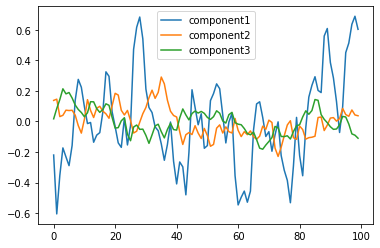

[0.77257101 0.08289321 0.06060263]


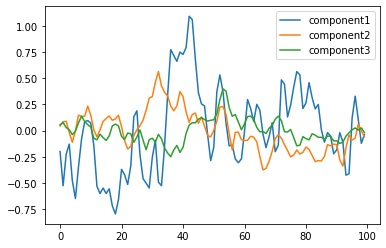

[0.70360483 0.15847487 0.05379608]


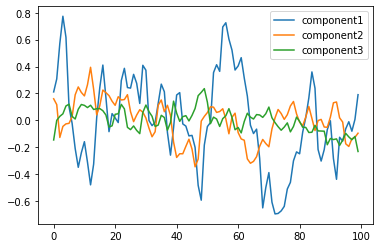

[0.7234849 0.1393348 0.0487557]


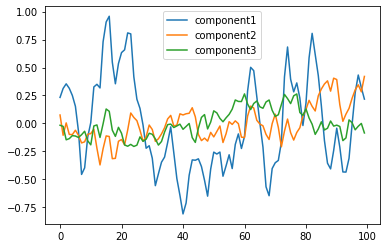

[0.7545689  0.11525305 0.06718753]


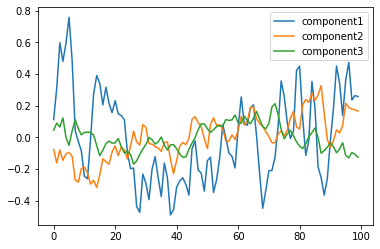

[0.69028544 0.16575532 0.06138534]


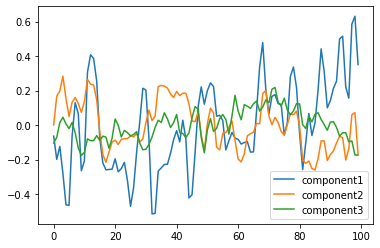

[0.62157904 0.18166767 0.07617857]


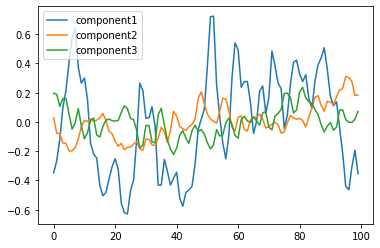

[0.75049338 0.08835741 0.06265348]
C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\2_4.mat


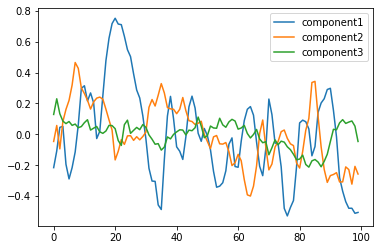

[0.63072579 0.25883514 0.05010048]


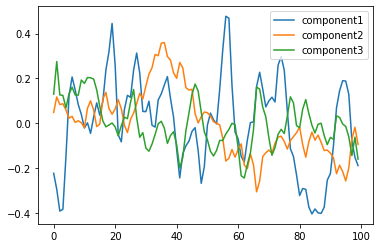

[0.51347094 0.25678067 0.13794442]


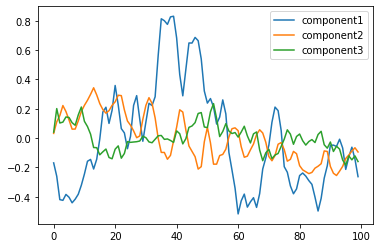

[0.7650251  0.15096693 0.04958864]


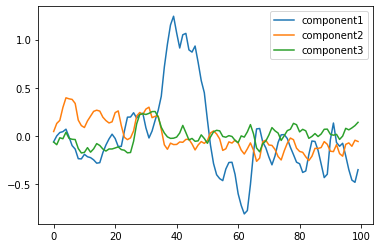

[0.79592505 0.11640587 0.04355923]


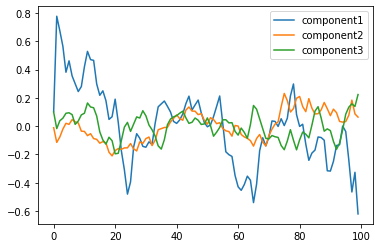

[0.76231236 0.11534656 0.08579606]


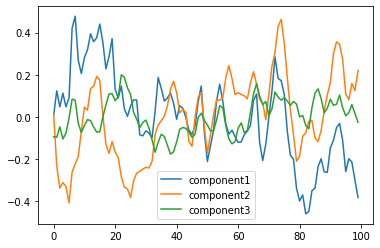

[0.44767793 0.39377706 0.07188011]


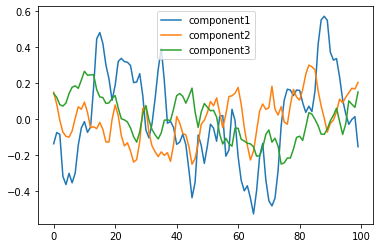

[0.63553181 0.15786857 0.13811831]
C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\3_6.mat


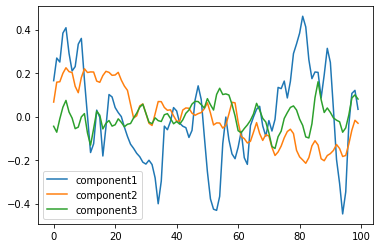

[0.662488   0.24285424 0.05241919]


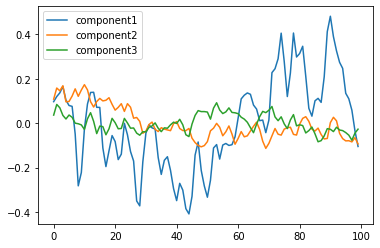

[0.82161554 0.10709059 0.03081643]


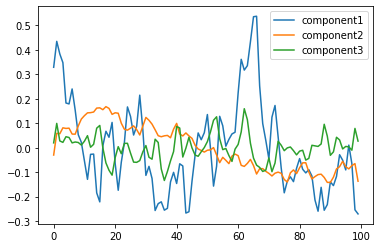

[0.72137491 0.17683112 0.06059615]


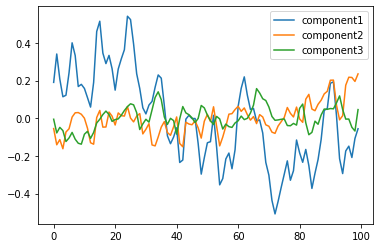

[0.80798413 0.10290846 0.0517889 ]


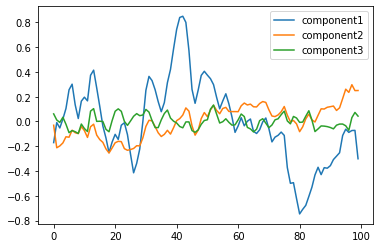

[0.83413356 0.12883171 0.0221177 ]


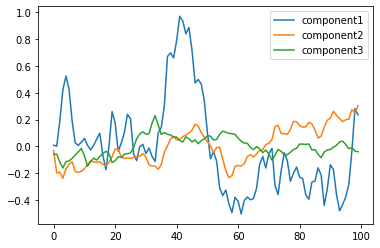

[0.79113706 0.12497128 0.03624626]


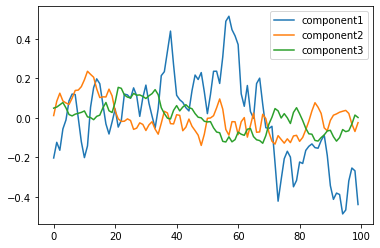

[0.7776528  0.10948546 0.08825173]
C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\4_1.mat


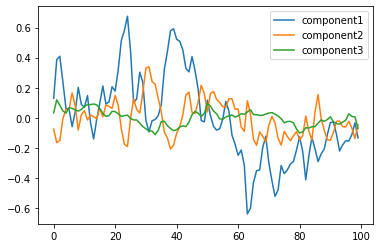

[0.80665963 0.14592015 0.02585929]


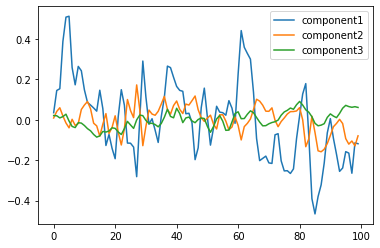

[0.84108062 0.09808527 0.03291959]


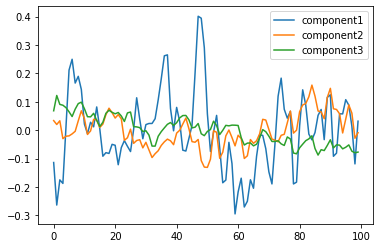

[0.67939645 0.1276225  0.09214156]


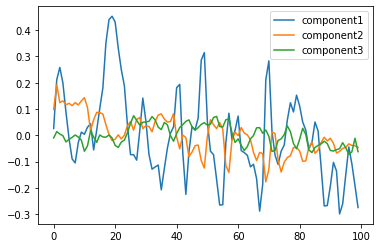

[0.76395855 0.15002938 0.04201889]


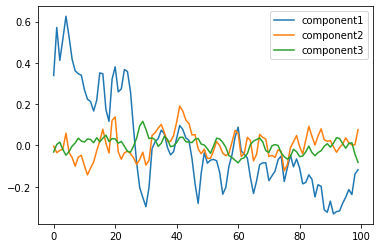

[0.88467746 0.06822794 0.0224249 ]


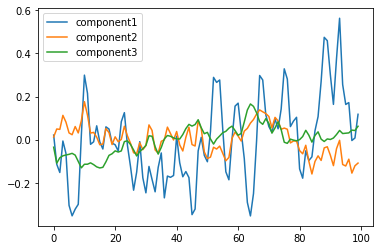

[0.77298158 0.09969487 0.08516914]


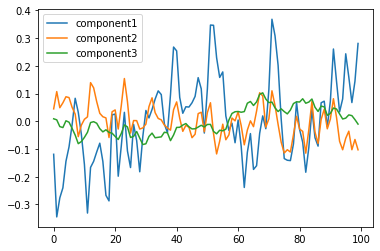

[0.75083119 0.11992729 0.07224608]
C:\Users\hyuns\Desktop\2020-2\캡스톤\EEGData\VR300\0729\hs\Online\5_3.mat


KeyboardInterrupt: 

In [48]:
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm
import hdf5storage
from scipy.signal import butter, lfilter
import os, glob, time
from datetime import datetime
from sklearn.externals import joblib
from scipy import signal
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car
    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
        
        Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def main():
        mat_path = root_path + 'Online\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime, reverse=True)
        score = 0
        
        pca_allT = np.zeros((len(current_list), 3, 100))
        pca_allN = np.zeros((len(current_list)*6, 3, 100))
        pca_allT_eig = np.zeros((len(current_list), 3))
        pca_allN_eig = np.zeros((len(current_list)*6, 3))
        
        index_T = 0
        index_N = 0
        for mat_file in current_list:
            print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            sampleNum = eegData.shape[1]
        
            #Common Average Reference
#             eegData = Re_referencing(eegData, channelNum, sampleNum)
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, 0.1, 30, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor(1.0 * samplingFreq))
            offset = int(np.floor(0.0 * samplingFreq))
            baseline = int(np.floor(1.0 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))
            
            featureNum = channelNum*resampleRate
            
            for i in range(buttonNum):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
            
            # PCA
            pca_all = np.zeros((7, 3, 100))
            pca = PCA(n_components=3) # 주성분을 몇개로 할지 결정
            
            label = ['component1', 'component2', 'component3']
            
            for i in range(buttonNum):
                pca_all[i] = pca.fit_transform(Epochs_final[i].transpose()).transpose()
    
                for j in range(3):    
                    plt.plot(pca_all[i,j,:], label = label[j])
                plt.legend()
                plt.show()
                print(pca.explained_variance_ratio_)
                
#                 if i == (int(ans)-1):
#                     pca_allT[index_T] = pca_all[i]
#                     pca_allT_eig[index_T] = pca.explained_variance_ratio_
#                     index_T = index_T + 1
#                 else:
#                     pca_allN[index_N] = pca_all[i]
#                     pca_allN_eig[index_N] = pca.explained_variance_ratio_
#                     index_N = index_N + 1
            
#             print('answer: ', ans)
        
#         pca_averT = np.mean(pca_allT, axis=0)
#         pca_averN = np.mean(pca_allN, axis=0)
#         label = ['component1', 'component2', 'component3']
        
#         pca_averT_eig = np.mean(pca_allT_eig, axis=0)
#         pca_averN_eig = np.mean(pca_allN_eig, axis=0)
        
#         for i in range(3):    
#             plt.plot(pca_averT[i], label = label[i])
#         plt.legend()
#         plt.show()
        
#         print(pca_averT_eig)
        
#         for i in range(3):
#             plt.plot(pca_averN[i], label=label[i])
#         plt.legend()
#         plt.show()
        
#         print(pca_averN_eig)
        
if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm
import hdf5storage
from scipy.signal import butter, lfilter
import os, glob, time
from datetime import datetime
from sklearn.externals import joblib
from scipy import signal
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car
    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
#         Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
        
        Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def main():
        mat_path = root_path + 'Online\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime, reverse=True)
        score = 0
        
        for mat_file in current_list:
            print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            sampleNum = eegData.shape[1]
        
            #Common Average Reference
#             eegData = Re_referen1cing(eegData, channelNum, sampleNum)
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, 0.1, 30, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor(1.0 * samplingFreq))
            offset = int(np.floor(0.0 * samplingFreq))
            baseline = int(np.floor(1.0 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))
            
            featureNum = channelNum*resampleRate
            
            for i in range(buttonNum):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
            
            # PCA
            componentNum = 3
            
            pca_all = np.zeros((buttonNum, componentNum, 100))
            pca = PCA(n_components=componentNum) # 주성분을 몇개로 할지 결정
            
            for i in range(buttonNum):
                pca_all[i] = pca.fit_transform(Epochs_final[i].transpose()).transpose()
                
            print('answer: ', ans)

if __name__ == "__main__":
    main()